# Índice - Rede Neural Didática
## por Caio Azevedo - [Jan;Julho] de 2020

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Learning Rate Decay](#Learning-Rate-Decay)

[Batch Normalization](#Batch-Normalization)

[Gradient Checking](#Gradient-Checking)

[Batch Generator](#Batch-Generator)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos da Rede Empírica](#Exemplos-da-Rede-Empírica)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)
    - [Early Stopping DEMO](#Early-Stopping-DEMO)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    - [Mapa Suscetibilidade POA](#Mapa-Suscetibilidade-POA)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import _pickle as pkl #utilizado para salvar/restaurar a rede
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plot
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Funções de Custo

###### Para Regressão

In [4]:
def mae(y,y_pred, derivative = False):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return np.mean(no.abs(y - y_pred))

def mse(y, y_pred, derivative = False):
    if derivative:
        return -(y - y_pred) / y.shape[0]
    return 0.5 * np.mean((y - y_pred) ** 2)    

###### Para Classificação Binária

In [5]:
def binary_cross_entropy(y, y_pred, derivative= False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])
    return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative= False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return -np.mean(y*np.log(y_sigmoid) +  (1 - y) * np.log(1 - y_sigmoid))  

###### Para Classificação Multiclasse

In [6]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

# Inicialização de Pesos

In [7]:
def zeros(rows,cols):
    return np.zeros((rows,cols))

def ones(rows,cols):
    return np.ones((rows,cols))

def random_normal(rows,cols):
    return np.random.randn(rows,cols)

def random_uniform(rows,cols):
    return np.random.rand(rows,cols)

def glorot_normal(rows,cols):
    std_dev = np.sqrt(2.0 / (rows + cols))
    return std_dev * np.random.randn(rows,cols)

def glorot_uniform(rows,cols):
    limit = np.sqrt(6.0 / (rows + cols))
    return 2.0 * limit * np.random.rand(rows, cols) - limit

# Regularização

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return np.array([np.where(w > 0, 1, w) for w in weights])
    return np.sum([np.abs(w) for w in weights])
                   
def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

# Batch Generator

In [9]:
def batch_sequential(x, y, batch_size=None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batches = x.shape[0] // batch_size
    
    for batch in range(n_batches):
        offset = batch_size * batch
        x_batch, y_batch = x[offset:offset+batch_size], y[offset:offset+batch_size]
        yield (x_batch, y_batch)
        
def batch_shuffle(x, y, batch_size=None):
    shuffle_index = np.random.permutation(range(x.shape[0])) #permutation shuffles the indexes
    return batch_sequential(x[shuffle_index],y[shuffle_index])

# Learning Rate Decay

In [10]:
def none_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate

def time_based_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return 1.0 / (1 + decay_rate * epoch)

def exponential_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate ** epoch

def staircase_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate ** (epoch // decay_steps)

# Batch Normalization 

In [11]:
def batchnorm_forward(layer, x, is_training = True):
    mu = np.mean(x, axis=0) if is_training else layer._pop_mean
    var = np.var(x,axis=0) if is_training else layer._pop_var
    x_norm = (x - mu) / np.sqrt(var+1e-8)
    out = layer.gamma * x_norm + layer.beta
    
    if is_training:
        layer._pop_mean = layer.bn_decay * layer._pop_mean + (1.0 - layer.bn_decay) * mu
        layer._pop_var = layer.bn_decay * layer._pop_var + (1.0 - layer.bn_decay) * var
        layer._bn_cache = (x, x_norm, mu, var)
    return out

def batchnorm_backward(layer, dactivation):
    x, x_norm, mu, var = layer._bn_cache
    
    m = layer._activ_inp.shape[0] #numero de amostras 
    x_mu = x - mu
    std_inv = 1.0 / np.sqrt(var + 1e-8) #inverso do desvio padrão
    
    dx_norm = dactivation * layer.gamma
    dvar = np.sum(dx_norm * x_mu, axis=0) * -0.5 * (std_inv ** 3)
    dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2.0 * x_mu, axis=0)
    
    dx = (dx_norm * std_inv) + (dvar * 2.0 * x_mu / m) + (dmu / m)
    layer._dgamma = np.sum(dactivation * x_norm, axis= 0)
    layer._dbeta = np.sum(dactivation, axis=0)
    return dx
    

## Gradient Checking

In [12]:
def __compute_approx_grads(nn, x, y, eps=1e-4): #calcula gradiente aproximado
    approx_grads = []   #gradientes aproximados por um epsilon qualquer (lim f(x+eps)-f(x)/eps, com eps->0)
    feed_forward = lambda inp: nn._NeuralNetwork__feedforward(inp, is_training=True) #simula trainamento da rede
                                                                            #f. lambda 'feed_forward' com parametro 'inp' que 
                                                                            #é passada para o metodo feedforward da rede nn
    #Para cada peso de cada camada são calculados os gradientes aproximados
    for layer in nn.layers:
        assert(layer.dropout_prob == 0), "Gradient checking can not be applied in ANN with DROPOUT"
        
        w_ori = layer.weights.copy() #copia para n alterar os pesos originais da rede
        w_ravel = w_ori.ravel()      #transforma array numa lista
        w_shape = w_ori.shape
        
        for i in range(w_ravel.size):
            w_plus = w_ravel.copy()
            w_plus[i] += eps
            layer.weights = w_plus.reshape(w_shape)
            J_plus = nn.cost_func(y, feed_forward(x)) + (1.0 / y.shape[0] * layer.reg_strength * layer.reg_func(layer.weights))
            
            w_minus = w_ravel.copy()
            w_minus[i] -= eps
            layer.weights = w_minus.reshape(w_shape)
            J_minus = nn.cost_func(y, feed_forward(x)) + (1.0 / y.shape[0] * layer.reg_strength * layer.reg_func(layer.weights))
            
            approx_grads.append((J_plus-J_minus) / (2.0 * eps))
        layer.weights = w_ori
    
    return approx_grads
    
#verifica qual proximos estao os gradientes reais e aproximados
def gradient_checking(nn, x, y, eps=1e-4, verbose=False, verbose_precision=5): #verifica se 
    from copy import deepcopy #utilizado para fazer copia de um objeto, no caso, da nn
    nn_copy = deepcopy(nn)
    
    nn.fit(x,y, epochs=0)
    grads = np.concatenate([layer._dweights.ravel() for layer in nn.layers]) #gradientes originais
    
    approx_grads = __compute_approx_grads(nn_copy,x, y, eps) #calcula os gradientes aproximados
    
    is_close = np.allclose(grads, approx_grads) #verifica se os gradientes são próximos com grande precisão, 8 casas
    print("{}".format("\033[92mGRADIENTES OK" if is_close else "\033[91mGRADIENTS FAIL"))
    
    #calculo dos erros relativos entre os gradientes (qq diferença menor que 1e-4 é aceitável)
    norm_num = np.linalg.norm(grads - approx_grads) #calcula norma das diferenças
    norm_den = np.linalg.norm(grads) + np.linalg.norm(approx_grads) # soma das normas
    error = norm_num / norm_den  #erro relativo (norma das diferenças / some das normas)
    print("Relative error", error)
    
    if verbose:
        np.set_printoptions(precision=verbose_precision, linewidth=200, suppress=True)
        print("Gradients", grads)
        print("Approximated", np.array(approx_grads))

# Implementação 

In [13]:
class Layer():
    def __init__(self, input_dim, output_dim, weights_initializer = random_normal, biases_initializer = ones, activation=linear, dropout_prob = 0.0, reg_func=l2_regularization, reg_strength=0, batch_norm=False, bn_decay=0.9, is_trainable=True):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim) #self.weights = np.random.randn(output_dim, input_dim)
        self.biases  = biases_initializer(1, output_dim) #self.biases  = np.random.randn(1, output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.reg_func = reg_func #(l1 or l2)
        self.reg_strength = reg_strength #(hyperparameter - lambda)
        
        #Batch Normalization
        self.batch_norm = batch_norm
        self.bn_decay = bn_decay
        self.gamma, self.beta = ones(1,output_dim),zeros(1,output_dim) #novos parametros da rede
        #Freezing in backpropagation
        self.is_trainable = is_trainable
        
        
        #prefixo '-', utilizado para atributo private
        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        #armazena os atributos que sofreram drop_out
        self._dropout_mask = None      
        self._dgamma, self._dbeta = None, None
        self._pop_mean, self._pop_var = zeros(1,output_dim), zeros(1,output_dim) #armazena estimativa da media e variança da população (batch norm.)
        self._bn_cache = None # (batch norm. armazena... )

class NeuralNetwork():
    def __init__(self,cost_func=mse, learning_rate = 1e-3, lr_decay_method = none_decay, lr_decay_rate= 0.0, lr_decay_steps = 1, momentum = 0.0, patience = np.inf):
        self.layers = []
        self.cost_func = cost_func
        #armazena lr inicial para os métodos de lr_decay
        self.learning_rate = self.lr_initial = learning_rate 
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        #
        self.momentum = momentum
        #early stopping - fator de paciencia e tempo de espera (em epochs)
        self.patience, self.waiting = patience, 0   
        self._best_model, self._best_loss = self.layers, np.inf
    
    def fit(self,x_train, y_train, x_val=None, y_val=None, epochs=100,verbose=10,batch_gen=batch_sequential, batch_size=None):
        #early stopping - inicializa um subset de validação com treinamento se não informado
        x_val, y_val = (x_train, y_train) if (x_val is None or y_val is None) else (x_val, y_val)
        
        for epoch in range(epochs + 1):
            #atualiza a learning rate, considerando um eventual decaimento 
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)
            #mini-bacth
            for x_batch, y_batch in batch_gen(x_train, y_train, batch_size):
                y_pred = self.__feedforward(x_batch)
                self.__backprop(y_batch,y_pred)
            #early stopping 
            loss_val = self.cost_func(y_val, self.predict(x_val)) #calcula perda em cada epoch
            if loss_val < self._best_loss:   #melhorou?
                self._best_model, self._best_loss = self.layers, loss_val
                self.waiting = 0   #reinicializa a espera
            else:
                self.waiting += 1
                #print("not improving! [{}] current: {} best: {}".format(self.waiting, loss_val, self._best_loss))
                if self.waiting >= self.patience:
                    self.layers = self._best_model
                    #print("early stopping at epoch ",epoch)
                    return
            
            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train,self.predict(x_train)) #loss function
                loss_reg = (1.0 / y_train.shape[0]) * np.sum([layer.reg_strength * layer.reg_func(layer.weights) for layer in self.layers]) #loss regularitazion
                print("epoch: {0:=4}/{1} loss_train: {2:.8f} + {3:.8f} = {4:.8f} loss_val = {5:.8f}".format(epoch,epochs,loss_train, loss_reg, loss_train + loss_reg,loss_val))
    
    def predict(self,x):
        return self.__feedforward(x, is_training=  False)
    
    #wb: write bytes; -1 sem compressão e tamanho ilimitado do arquivo
    def save(self, file_path):
        pkl.dump(self,open(file_path, 'wb'), -1)
    
    def load(file_path):
        return pkl.load(open(file_path,'rb')) #rb read bytes
    
    #'__' esse prefixo torna o 'método privado'
    def __feedforward(self,x,is_training = True):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0,0)]): #adição do layer vazio para ambos possuam o mesmo tamanho
            y = np.dot(current_layer.input,current_layer.weights.T) + current_layer.biases #calculo da entrada da função de ativação
            #batch normalization
            y = batchnorm_forward(current_layer, y, is_training) if current_layer.batch_norm else y
            #cria uma máscara ativação (liga/desliga) dos neuronios baseado na probabilidade além de reescalar as ativações para cada iteração.
            current_layer._dropout_mask = np.random.binomial(1,(1.0 - current_layer.dropout_prob),y.shape) / (1.0 - current_layer.dropout_prob)
            current_layer._activ_inp = y
            
            #calculo da f. ativacao (saida da atual é a entrada da próxima) & aplica máscara de 
            current_layer._activ_out = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1)  
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
        
    #calcula as derivada e atualiza os pesos e bias
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            #derivada da f. de ativação, somente daqueles neuronios ativos (por conta do drop_out)
            dactivation = layer.activation(layer._activ_inp,derivative=True) * last_delta * layer._dropout_mask
            #batch normalization - 
            dactivation = batchnorm_backward(layer, dactivation) if layer.batch_norm else dactivation
            
            last_delta = np.dot(dactivation, layer.weights) 
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0 * dactivation.sum(axis=0, keepdims=True)
            
        for layer in reversed(self.layers):
            if layer.is_trainable:
                #incrementa backprop com a derivada da regularização (l1 ou l2) antes de atualizar os pesos 
                layer._dweights = layer._dweights + (1.0 / y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights,derivative=True)

                #calcula o gradiante da iteração anterior aplicando o fator de momentum (atualização dos pesos)
                layer._prev_dweights = -self.learning_rate * layer._dweights + (self.momentum * layer._prev_dweights)
                layer.weights = layer.weights + layer._prev_dweights 
                #layer.weights = layer.weights - self.learning_rate * layer._dweights # atualização dos pesos sem momentum

                layer.biases = layer.biases - self.learning_rate * layer._dbiases
                #batch normalization - gamma e beta são novos parametros da rede, assim como pesos e bias
                if layer.batch_norm:
                    layer.gamma = layer.gamma - self.learning_rate * layer._dgamma
                    layer.beta = layer.beta - self.learning_rate * layer._dbeta

## Exemplos da Rede Empírica

### Exemplo 1

In [14]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) 
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

# Configuração da rede aqui..
input_dim, output_dim = x.shape[1], y.shape[1] #numero de colunas da entrada e saida
nn = NeuralNetwork(cost_func = mse, learning_rate = 0.5)
nn.layers.append(Layer(input_dim=input_dim, output_dim=2,activation=sigmoid)) #a saida de uma camada é a entrada da próxima (2 nesse caso)
nn.layers.append(Layer(input_dim=2, output_dim=output_dim,activation=sigmoid))

#normalmente são numeros aleatórios, mas para fins didáticos
nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x,y, epochs=0,verbose=1)

for layer in nn.layers:
    print(layer.weights)
    
print("Trainable == False")    
#for layer in nn.layers:
for layer in nn.layers[:-1]: #congela todas as camadas menos a ultima
    layer.is_trainable = False
    
nn.fit(x, y, epochs=1000, verbose=100)    
for layer in nn.layers:
    print(layer.weights)

epoch:    0/0 loss_train: 0.14023572 + 0.00000000 = 0.14023572 loss_val = 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]
Trainable == False
epoch:    0/1000 loss_train: 0.13098517 + 0.00000000 = 0.13098517 loss_val = 0.13098517
epoch:  100/1000 loss_train: 0.00326789 + 0.00000000 = 0.00326789 loss_val = 0.00326789
epoch:  200/1000 loss_train: 0.00142285 + 0.00000000 = 0.00142285 loss_val = 0.00142285
epoch:  300/1000 loss_train: 0.00086728 + 0.00000000 = 0.00086728 loss_val = 0.00086728
epoch:  400/1000 loss_train: 0.00060653 + 0.00000000 = 0.00060653 loss_val = 0.00060653
epoch:  500/1000 loss_train: 0.00045743 + 0.00000000 = 0.00045743 loss_val = 0.00045743
epoch:  600/1000 loss_train: 0.00036192 + 0.00000000 = 0.00036192 loss_val = 0.00036192
epoch:  700/1000 loss_train: 0.00029601 + 0.00000000 = 0.00029601 loss_val = 0.00029601
epoch:  800/1000 loss_train: 0.00024808 + 0.00000000 = 0.00024808 loss_val = 0.00024808
ep

### Exemplo 2

In [15]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

# Configuração da rede aqui..
D_in, D_out = x.shape[1], y.shape[1] #numero de colunas da entrada e saida
nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 0.01)
nn.layers.append(Layer(input_dim=D_in, output_dim=3,activation=relu)) #a saida de uma camada é a entrada da próxima (2 nesse caso)
nn.layers.append(Layer(input_dim=3, output_dim=3,activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out,activation=linear))

for i,w,b in zip(range(3), [w1,w2,w3], [b1,b2,b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b
    
nn.fit(x, y, epochs=300, verbose=30)

for layer in nn.layers:
    print(layer.weights)


epoch:    0/300 loss_train: 1.14054966 + 0.00000000 = 1.14054966 loss_val = 1.14054966
epoch:   30/300 loss_train: 0.59630022 + 0.00000000 = 0.59630022 loss_val = 0.59630022
epoch:   60/300 loss_train: 0.36031189 + 0.00000000 = 0.36031189 loss_val = 0.36031189
epoch:   90/300 loss_train: 0.24668884 + 0.00000000 = 0.24668884 loss_val = 0.24668884
epoch:  120/300 loss_train: 0.18386202 + 0.00000000 = 0.18386202 loss_val = 0.18386202
epoch:  150/300 loss_train: 0.14510157 + 0.00000000 = 0.14510157 loss_val = 0.14510157
epoch:  180/300 loss_train: 0.11918285 + 0.00000000 = 0.11918285 loss_val = 0.11918285
epoch:  210/300 loss_train: 0.10078511 + 0.00000000 = 0.10078511 loss_val = 0.10078511
epoch:  240/300 loss_train: 0.08712037 + 0.00000000 = 0.08712037 loss_val = 0.08712037
epoch:  270/300 loss_train: 0.07660623 + 0.00000000 = 0.07660623 loss_val = 0.07660623
epoch:  300/300 loss_train: 0.06828531 + 0.00000000 = 0.06828531 loss_val = 0.06828531
[[0.10083595 0.2016719  0.30585165]
 [0.300

## Gradient Checking

In [16]:
np.random.seed(1234)
N, D = 100, 2 #100 amostra de 2 dimensoes
x = np.random.rand(N, D)

In [17]:
y = np.random.rand(N, 1)

#nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
#nn.layers.append(Layer(input_dim=x.shape[1], output_dim=4, activation=relu))
#nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh))
#nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid))
#nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu))
#nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu))
#nn.layers.append(Layer(input_dim=3, output_dim=y.shape[1], activation=linear))

#nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9, lr_decay_method =staircase_decay, lr_decay_rate=0.5, lr_decay_steps=10)
#nn.layers.append(Layer(input_dim=x.shape[1], output_dim=4, activation=relu, batch_norm=True))
#nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh))
#nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, batch_norm=True))
#nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu))
#nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu, batch_norm=True))
#nn.layers.append(Layer(input_dim=3, output_dim=y.shape[1], activation=linear, batch_norm=True))

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9, lr_decay_method =staircase_decay, lr_decay_rate=0.5, lr_decay_steps=10)
nn.layers.append(Layer(input_dim=x.shape[1], output_dim=4, activation=relu, reg_func=l2_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh,reg_func=l1_regularization,reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu,reg_func=l2_regularization,reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu,reg_func=l1_regularization,reg_strength=1e-3, batch_norm=True))
nn.layers.append(Layer(input_dim=3, output_dim=y.shape[1], activation=linear,reg_func=l2_regularization,reg_strength=1e-3, batch_norm=True))

nn.fit(x,y, epochs=100)

gradient_checking(nn, x, y, eps=1e-4, verbose=True)


epoch:    0/100 loss_train: 88.38684914 + 0.06734337 = 88.45419251 loss_val = 88.38684914
epoch:   10/100 loss_train: 2.32636923 + 0.06728253 = 2.39365176 loss_val = 2.32636923
epoch:   20/100 loss_train: 1.08976488 + 0.06720744 = 1.15697232 loss_val = 1.08976488
epoch:   30/100 loss_train: 0.78860462 + 0.06715436 = 0.85575898 loss_val = 0.78860462
epoch:   40/100 loss_train: 0.68906324 + 0.06712241 = 0.75618566 loss_val = 0.68906324
epoch:   50/100 loss_train: 0.65380222 + 0.06710455 = 0.72090677 loss_val = 0.65380222
epoch:   60/100 loss_train: 0.64127602 + 0.06709496 = 0.70837098 loss_val = 0.64127602
epoch:   70/100 loss_train: 0.63677098 + 0.06708994 = 0.70386092 loss_val = 0.63677098
epoch:   80/100 loss_train: 0.63512653 + 0.06708735 = 0.70221388 loss_val = 0.63512653
epoch:   90/100 loss_train: 0.63451492 + 0.06708602 = 0.70160094 loss_val = 0.63451492
epoch:  100/100 loss_train: 0.63428214 + 0.06708535 = 0.70136750 loss_val = 0.63428214
epoch:    0/0 loss_train: 0.63312129 + 0

In [18]:
y = np.random.randint(0, 2, (N,1)) #classificacao binária

#nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3, momentum=0.9, lr_decay_method =staircase_decay, lr_decay_rate=0.5, lr_decay_steps=10)
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-3, momentum=0.9, lr_decay_method =staircase_decay, lr_decay_rate=0.5, lr_decay_steps=10)
nn.layers.append(Layer(input_dim=x.shape[1], output_dim=4, activation=relu, reg_func=l2_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh,reg_func=l1_regularization,reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu,reg_func=l2_regularization,reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu,reg_func=l1_regularization,reg_strength=1e-3, batch_norm=True))
#nn.layers.append(Layer(input_dim=3, output_dim=y.shape[1], activation=linear,reg_func=l2_regularization,reg_strength=1e-3, batch_norm=True))
nn.layers.append(Layer(input_dim=3, output_dim=y.shape[1], activation=sigmoid,reg_func=l2_regularization,reg_strength=1e-3, batch_norm=True))

nn.fit(x,y, epochs=100)

gradient_checking(nn, x, y, eps=1e-4, verbose=True)


epoch:    0/100 loss_train: 19.72440455 + 0.07338091 = 19.79778546 loss_val = 19.72440455
epoch:   10/100 loss_train: 1.03356181 + 0.07332291 = 1.10688471 loss_val = 1.03356181
epoch:   20/100 loss_train: 0.85065021 + 0.07325132 = 0.92390153 loss_val = 0.85065021
epoch:   30/100 loss_train: 0.86276676 + 0.07320071 = 0.93596747 loss_val = 0.86276676
epoch:   40/100 loss_train: 0.89263981 + 0.07317025 = 0.96581005 loss_val = 0.89263981
epoch:   50/100 loss_train: 0.90506844 + 0.07315321 = 0.97822166 loss_val = 0.90506844
epoch:   60/100 loss_train: 0.90951636 + 0.07314407 = 0.98266043 loss_val = 0.90951636
epoch:   70/100 loss_train: 0.91113217 + 0.07313928 = 0.98427146 loss_val = 0.91113217
epoch:   80/100 loss_train: 0.91172324 + 0.07313681 = 0.98486005 loss_val = 0.91172324
epoch:   90/100 loss_train: 0.91194303 + 0.07313555 = 0.98507858 loss_val = 0.91194303
epoch:  100/100 loss_train: 0.91202663 + 0.07313491 = 0.98516154 loss_val = 0.91202663
epoch:    0/0 loss_train: 0.91188728 + 0

In [19]:
y = np.random.randint(0, 3, (N,1)) #classificacao multiclasse

y_oh = OneHotEncoder(sparse=False).fit_transform(y)

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-3, momentum=0.9, lr_decay_method =staircase_decay, lr_decay_rate=0.5, lr_decay_steps=10)
nn.layers.append(Layer(input_dim=x.shape[1], output_dim=4, activation=relu, reg_func=l2_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh,reg_func=l1_regularization,reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu,reg_func=l2_regularization,reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu,reg_func=l1_regularization,reg_strength=1e-3, batch_norm=True))
nn.layers.append(Layer(input_dim=3, output_dim=y_oh.shape[1], activation=linear,reg_func=l2_regularization,reg_strength=1e-3, batch_norm=True))

nn.fit(x,y, epochs=100)

gradient_checking(nn, x, y_oh, eps=1e-4, verbose=True)

epoch:    0/100 loss_train: 18.79478428 + 0.06947947 = 18.86426376 loss_val = 18.79478428
epoch:   10/100 loss_train: 2.44040574 + 0.06942710 = 2.50983285 loss_val = 2.44040574
epoch:   20/100 loss_train: 1.58624890 + 0.06936251 = 1.65561141 loss_val = 1.58624890
epoch:   30/100 loss_train: 1.50104408 + 0.06931688 = 1.57036096 loss_val = 1.50104408
epoch:   40/100 loss_train: 1.50642382 + 0.06928949 = 1.57571330 loss_val = 1.50642382
epoch:   50/100 loss_train: 1.51624064 + 0.06927419 = 1.58551483 loss_val = 1.51624064
epoch:   60/100 loss_train: 1.52230394 + 0.06926598 = 1.59156992 loss_val = 1.52230394
epoch:   70/100 loss_train: 1.52571623 + 0.06926168 = 1.59497791 loss_val = 1.52571623
epoch:   80/100 loss_train: 1.52760585 + 0.06925946 = 1.59686531 loss_val = 1.52760585
epoch:   90/100 loss_train: 1.52864428 + 0.06925833 = 1.59790261 loss_val = 1.52864428
epoch:  100/100 loss_train: 1.52920872 + 0.06925775 = 1.59846647 loss_val = 1.52920872
epoch:    0/0 loss_train: 1.47597456 + 0

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

(100, 2)
(100, 1) (100, 1)


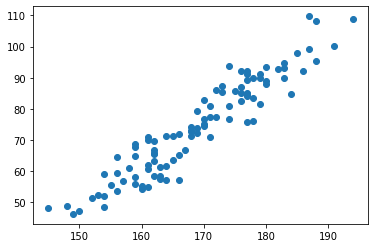

In [20]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x, y)

-1.0 0.9999999999999991


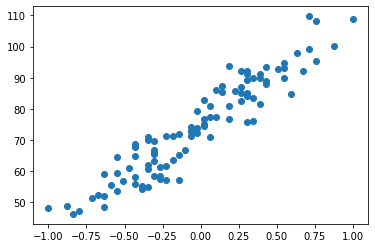

In [21]:
#normalização dos dados entre -1 e 1
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())
plt.scatter(x, y)

epoch:    0/5000 loss_train: 2765.07158505 + 0.00000000 = 2765.07158505 loss_val = 2765.07158505
epoch:  500/5000 loss_train: 34.13359802 + 0.00000000 = 34.13359802 loss_val = 34.13359802
epoch: 1000/5000 loss_train: 16.27234592 + 0.00000000 = 16.27234592 loss_val = 16.27234592
epoch: 1500/5000 loss_train: 13.53901206 + 0.00000000 = 13.53901206 loss_val = 13.53901206
epoch: 2000/5000 loss_train: 13.11808048 + 0.00000000 = 13.11808048 loss_val = 13.11808048
epoch: 2500/5000 loss_train: 13.05325719 + 0.00000000 = 13.05325719 loss_val = 13.05325719
epoch: 3000/5000 loss_train: 13.04327443 + 0.00000000 = 13.04327443 loss_val = 13.04327443
epoch: 3500/5000 loss_train: 13.04173709 + 0.00000000 = 13.04173709 loss_val = 13.04173709
epoch: 4000/5000 loss_train: 13.04150034 + 0.00000000 = 13.04150034 loss_val = 13.04150034
epoch: 4500/5000 loss_train: 13.04146388 + 0.00000000 = 13.04146388 loss_val = 13.04146388
epoch: 5000/5000 loss_train: 13.04145826 + 0.00000000 = 13.04145826 loss_val = 13.04

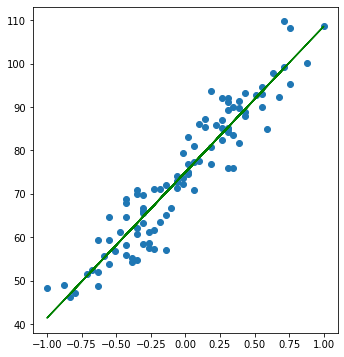

In [22]:
input_dim, output_dim = x.shape[1], y.shape[1]

# solução para o problema de regressão aqui - dependendo da learnig rate, c precisa de mais ou menos epochs
nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-2)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim,activation=linear))  #basta um perceptron (camada)

#aprendizado da rede
nn.fit(x, y, epochs=5000, verbose=500)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [23]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [24]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [1. 1. 1.]


In [25]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim,activation=linear)) #apenas uma camadas pois estamos reproduzindo um perceptrom

nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)


epoch:    0/2000 loss_train: 9951.27062944 + 0.00000000 = 9951.27062944 loss_val = 9951.27062944
epoch:  200/2000 loss_train: 6.42569494 + 0.00000000 = 6.42569494 loss_val = 6.42569494
epoch:  400/2000 loss_train: 3.85555266 + 0.00000000 = 3.85555266 loss_val = 3.85555266
epoch:  600/2000 loss_train: 3.17270607 + 0.00000000 = 3.17270607 loss_val = 3.17270607
epoch:  800/2000 loss_train: 2.97331316 + 0.00000000 = 2.97331316 loss_val = 2.97331316
epoch: 1000/2000 loss_train: 2.90831881 + 0.00000000 = 2.90831881 loss_val = 2.90831881
epoch: 1200/2000 loss_train: 2.88481190 + 0.00000000 = 2.88481190 loss_val = 2.88481190
epoch: 1400/2000 loss_train: 2.87559713 + 0.00000000 = 2.87559713 loss_val = 2.87559713
epoch: 1600/2000 loss_train: 2.87178761 + 0.00000000 = 2.87178761 loss_val = 2.87178761
epoch: 1800/2000 loss_train: 2.87016231 + 0.00000000 = 2.87016231 loss_val = 2.87016231
epoch: 2000/2000 loss_train: 2.86945669 + 0.00000000 = 2.86945669 loss_val = 2.86945669
[[ 8.90818 13.99564 26.

### Regressão Quadrática

(100, 1) (100, 1)


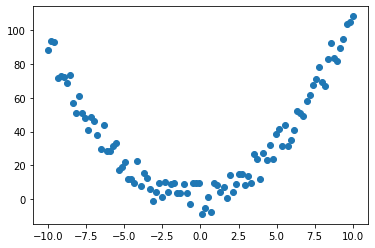

In [26]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [27]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000 loss_train: 1053.69590661 + 0.00000000 = 1053.69590661 loss_val = 1053.69590661
epoch:  500/5000 loss_train: 31.69181756 + 0.00000000 = 31.69181756 loss_val = 31.69181756
epoch: 1000/5000 loss_train: 24.41231597 + 0.00000000 = 24.41231597 loss_val = 24.41231597
epoch: 1500/5000 loss_train: 24.77717126 + 0.00000000 = 24.77717126 loss_val = 24.77717126
epoch: 2000/5000 loss_train: 22.89205224 + 0.00000000 = 22.89205224 loss_val = 22.89205224
epoch: 2500/5000 loss_train: 20.95733232 + 0.00000000 = 20.95733232 loss_val = 20.95733232
epoch: 3000/5000 loss_train: 19.31007074 + 0.00000000 = 19.31007074 loss_val = 19.31007074
epoch: 3500/5000 loss_train: 19.52688206 + 0.00000000 = 19.52688206 loss_val = 19.52688206
epoch: 4000/5000 loss_train: 17.12623822 + 0.00000000 = 17.12623822 loss_val = 17.12623822
epoch: 4500/5000 loss_train: 16.23440230 + 0.00000000 = 16.23440230 loss_val = 16.23440230
epoch: 5000/5000 loss_train: 15.73601960 + 0.00000000 = 15.73601960 loss_val = 15.73

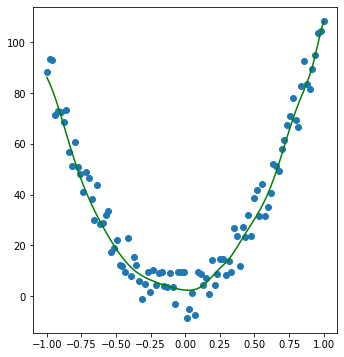

In [28]:
input_dim, output_dim = x.shape[1], y.shape[1]

# para solução é necessario definir -  # de camadas ? # de neuronios por camada, qual função ativação ?
# no entanto temos: # neuronios ultima camada = # de saídas (o caso 1, que é o Y)
# por ser um problema de regressão a função da saída tem que ser linear 
#nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-3) #sem momentum
nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-3, momentum=0.9) #inclusão do momentum para reduzir a quantidade de epochs e aumentar taxa de 
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=tanh)) #entrada dessa camada é a saída da anterior 
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim,activation=linear)) 
#aqui precisei de mais de uma camada pois não é um problema linear 
nn.fit(x, y, epochs=5000, verbose=500)

#print(nn.layers[0].weights)
#print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

(100, 1) (100, 1)


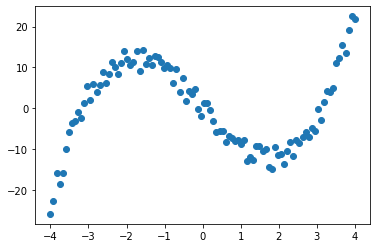

In [29]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [30]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000 loss_train: 56.00483253 + 0.00000000 = 56.00483253 loss_val = 56.00483253
epoch:  500/5000 loss_train: 9.50563682 + 0.00000000 = 9.50563682 loss_val = 9.50563682
epoch: 1000/5000 loss_train: 5.10425654 + 0.00000000 = 5.10425654 loss_val = 5.10425654
epoch: 1500/5000 loss_train: 4.06529417 + 0.00000000 = 4.06529417 loss_val = 4.06529417
epoch: 2000/5000 loss_train: 3.68447293 + 0.00000000 = 3.68447293 loss_val = 3.68447293
epoch: 2500/5000 loss_train: 3.37290199 + 0.00000000 = 3.37290199 loss_val = 3.37290199
epoch: 3000/5000 loss_train: 3.13500297 + 0.00000000 = 3.13500297 loss_val = 3.13500297
epoch: 3500/5000 loss_train: 3.00305745 + 0.00000000 = 3.00305745 loss_val = 3.00305745
epoch: 4000/5000 loss_train: 2.83800419 + 0.00000000 = 2.83800419 loss_val = 2.83800419
epoch: 4500/5000 loss_train: 2.72352140 + 0.00000000 = 2.72352140 loss_val = 2.72352140
epoch: 5000/5000 loss_train: 2.63660829 + 0.00000000 = 2.63660829 loss_val = 2.63660829
[[ 2.09423]
 [-1.32287]
 [-3.

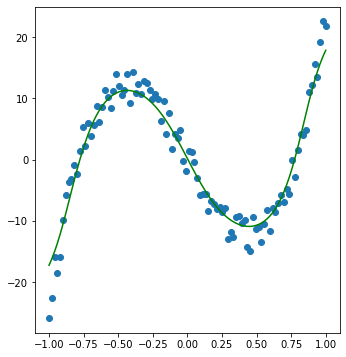

In [31]:
input_dim, output_dim = x.shape[1], y.shape[1]

# para solução é necessario definir -  # de camadas ? # de neuronios por camada, qual função ativação ?
# no entanto temos: # neuronios ultima camada = # de saídas (o caso 1, que é o Y)
# por ser um problema de regressão a função da saída tem que ser linear 
nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-3)

nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=tanh))


nn.layers.append(Layer(input_dim=10, output_dim=50, activation=tanh,dropout_prob=0.5)) #só se aplica dropout nas camadas intermediárias
nn.layers.append(Layer(input_dim=50, output_dim=output_dim,activation=linear)) #entrada dessa camada é a saída da anterior 
#aqui precisei de mais de uma camada pois não é um problema linear 
nn.fit(x, y, epochs=5000, verbose=500)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

(100, 1) (100, 1)


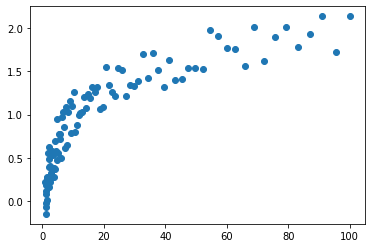

In [32]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [33]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/10000 loss_train: 0.38973423 + 0.00000000 = 0.38973423 loss_val = 0.38973423
epoch: 1000/10000 loss_train: 0.10861773 + 0.00000000 = 0.10861773 loss_val = 0.10861773
epoch: 2000/10000 loss_train: 0.07445209 + 0.00000000 = 0.07445209 loss_val = 0.07445209
epoch: 3000/10000 loss_train: 0.04740237 + 0.00000000 = 0.04740237 loss_val = 0.04740237
epoch: 4000/10000 loss_train: 0.03088679 + 0.00000000 = 0.03088679 loss_val = 0.03088679
epoch: 5000/10000 loss_train: 0.02312467 + 0.00000000 = 0.02312467 loss_val = 0.02312467
epoch: 6000/10000 loss_train: 0.01926542 + 0.00000000 = 0.01926542 loss_val = 0.01926542
epoch: 7000/10000 loss_train: 0.01721985 + 0.00000000 = 0.01721985 loss_val = 0.01721985
epoch: 8000/10000 loss_train: 0.01606265 + 0.00000000 = 0.01606265 loss_val = 0.01606265
epoch: 9000/10000 loss_train: 0.01536653 + 0.00000000 = 0.01536653 loss_val = 0.01536653
epoch: 10000/10000 loss_train: 0.01492312 + 0.00000000 = 0.01492312 loss_val = 0.01492312
[[ 0.05494]
 [ 0.365

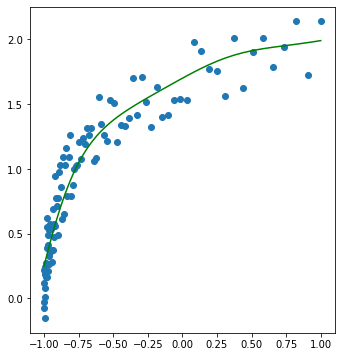

In [34]:
input_dim, output_dim = x.shape[1], y.shape[1]

# para solução é necessario definir -  # de camadas ? # de neuronios por camada, qual função ativação ?
# no entanto temos: # neuronios ultima camada = # de saídas (o caso 1, que é o Y)
# por ser um problema de regressão a função da saída tem que ser linear 
nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim,activation=linear)) #entrada dessa camada é a saída da anterior 
#aqui precisei de mais de uma camada pois não é um problema linear 
nn.fit(x, y, epochs=10000, verbose=1000)

print(nn.layers[0].weights)
print(nn.layers[0].biases)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

(100, 1) (100, 1)


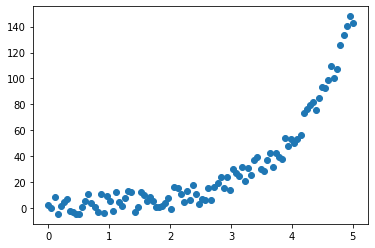

In [35]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [36]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/5000 loss_train: 1054.82373255 + 0.00000000 = 1054.82373255 loss_val = 1054.82373255
epoch:  500/5000 loss_train: 15.88675849 + 0.00000000 = 15.88675849 loss_val = 15.88675849
epoch: 1000/5000 loss_train: 14.81843630 + 0.00000000 = 14.81843630 loss_val = 14.81843630
epoch: 1500/5000 loss_train: 14.61631644 + 0.00000000 = 14.61631644 loss_val = 14.61631644
epoch: 2000/5000 loss_train: 14.57394822 + 0.00000000 = 14.57394822 loss_val = 14.57394822
epoch: 2500/5000 loss_train: 14.54833625 + 0.00000000 = 14.54833625 loss_val = 14.54833625
epoch: 3000/5000 loss_train: 14.52753943 + 0.00000000 = 14.52753943 loss_val = 14.52753943
epoch: 3500/5000 loss_train: 14.51228257 + 0.00000000 = 14.51228257 loss_val = 14.51228257
epoch: 4000/5000 loss_train: 14.50005296 + 0.00000000 = 14.50005296 loss_val = 14.50005296
epoch: 4500/5000 loss_train: 14.48976860 + 0.00000000 = 14.48976860 loss_val = 14.48976860
epoch: 5000/5000 loss_train: 14.48102310 + 0.00000000 = 14.48102310 loss_val = 14.48

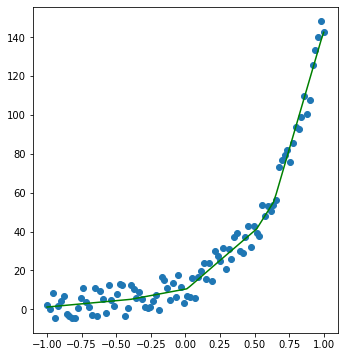

In [37]:
input_dim, output_dim = x.shape[1], y.shape[1]

# para solução é necessario definir -  # de camadas ? # de neuronios por camada, qual função ativação ?
# aqui relu ou tanh deu no mesmo
# no entanto temos: # neuronios ultima camada = # de saídas (o caso 1, que é o Y)
# por ser um problema de regressão a função da saída tem que ser linear 
nn = NeuralNetwork(cost_func = mse, learning_rate = 1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim,activation=linear)) #entrada dessa camada é a saída da anterior 
#aqui precisei de mais de uma camada pois não é um problema linear 
nn.fit(x, y, epochs=5000, verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

(4, 2) (4, 1)


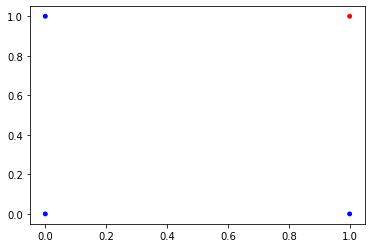

In [38]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: 0.91832022 + 0.00000000 = 0.91832022 loss_val = 0.91832022
epoch:  100/1000 loss_train: 0.14578631 + 0.00000000 = 0.14578631 loss_val = 0.14578631
epoch:  200/1000 loss_train: 0.08231772 + 0.00000000 = 0.08231772 loss_val = 0.08231772
epoch:  300/1000 loss_train: 0.05684902 + 0.00000000 = 0.05684902 loss_val = 0.05684902
epoch:  400/1000 loss_train: 0.04322893 + 0.00000000 = 0.04322893 loss_val = 0.04322893
epoch:  500/1000 loss_train: 0.03479505 + 0.00000000 = 0.03479505 loss_val = 0.03479505
epoch:  600/1000 loss_train: 0.02907690 + 0.00000000 = 0.02907690 loss_val = 0.02907690
epoch:  700/1000 loss_train: 0.02495262 + 0.00000000 = 0.02495262 loss_val = 0.02495262
epoch:  800/1000 loss_train: 0.02184122 + 0.00000000 = 0.02184122 loss_val = 0.02184122
epoch:  900/1000 loss_train: 0.01941246 + 0.00000000 = 0.01941246 loss_val = 0.01941246
epoch: 1000/1000 loss_train: 0.01746508 + 0.00000000 = 0.01746508 loss_val = 0.01746508
Predições:
[[0.00001]
 [0.0203 ]

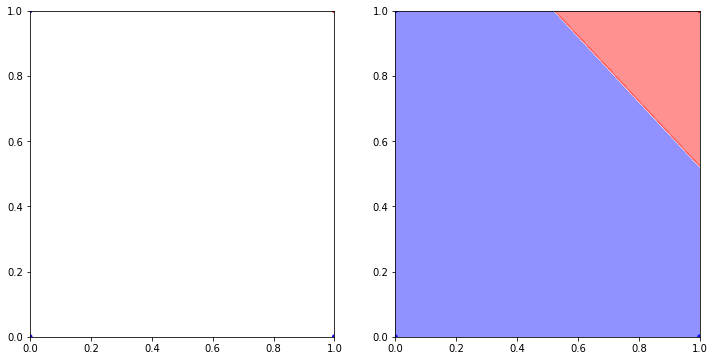

In [39]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs = 1000, verbose = 100)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold= 0.5, cmap='bwr')

### Porta XOR

(4, 2) (4, 1)


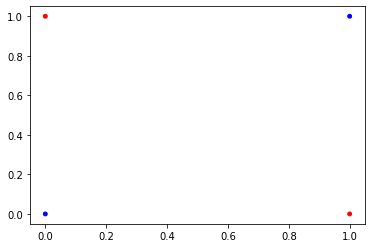

In [40]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: 0.69567207 + 0.00000000 = 0.69567207 loss_val = 0.69567207
epoch:  100/1000 loss_train: 0.68664699 + 0.00000000 = 0.68664699 loss_val = 0.68664699
epoch:  200/1000 loss_train: 0.62749645 + 0.00000000 = 0.62749645 loss_val = 0.62749645
epoch:  300/1000 loss_train: 0.48649162 + 0.00000000 = 0.48649162 loss_val = 0.48649162
epoch:  400/1000 loss_train: 0.14924749 + 0.00000000 = 0.14924749 loss_val = 0.14924749
epoch:  500/1000 loss_train: 0.06444141 + 0.00000000 = 0.06444141 loss_val = 0.06444141
epoch:  600/1000 loss_train: 0.03987547 + 0.00000000 = 0.03987547 loss_val = 0.03987547
epoch:  700/1000 loss_train: 0.02861015 + 0.00000000 = 0.02861015 loss_val = 0.02861015
epoch:  800/1000 loss_train: 0.02221530 + 0.00000000 = 0.02221530 loss_val = 0.02221530
epoch:  900/1000 loss_train: 0.01811543 + 0.00000000 = 0.01811543 loss_val = 0.01811543
epoch: 1000/1000 loss_train: 0.01527166 + 0.00000000 = 0.01527166 loss_val = 0.01527166
Predições:
[[0.01474]
 [0.98588]

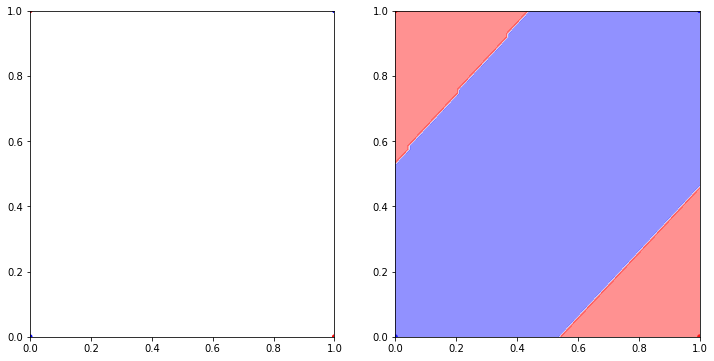

In [41]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100 )

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold= 0.5, cmap='bwr')

### 2 Clusters

(100, 2) (100, 1)


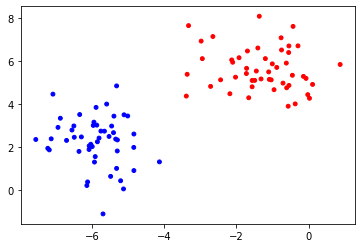

In [42]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000 loss_train: 3.29721714 + 0.00000000 = 3.29721714 loss_val = 3.29721714
epoch: 1000/5000 loss_train: 0.00598165 + 0.00000000 = 0.00598165 loss_val = 0.00598165
epoch: 2000/5000 loss_train: 0.00403584 + 0.00000000 = 0.00403584 loss_val = 0.00403584
epoch: 3000/5000 loss_train: 0.00320408 + 0.00000000 = 0.00320408 loss_val = 0.00320408
epoch: 4000/5000 loss_train: 0.00271467 + 0.00000000 = 0.00271467 loss_val = 0.00271467
epoch: 5000/5000 loss_train: 0.00238250 + 0.00000000 = 0.00238250 loss_val = 0.00238250
Acurácia: 100.00%


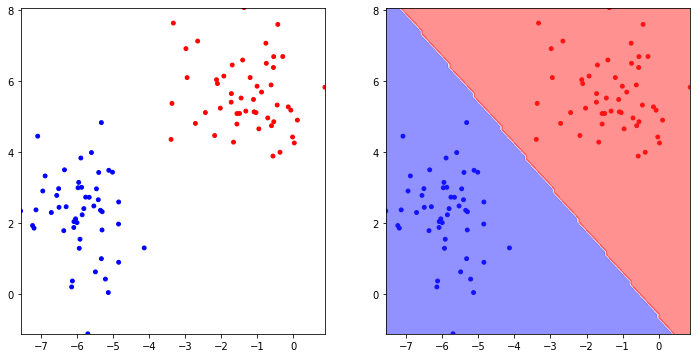

In [43]:
input_dim, output_dim = x.shape[1], y.shape[1]

#configuração da rede - problema de classificação binária (binary_cross_entropy)
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate = 1e-1)
#1 neurônio é suficiente pois é possivel separar as classes com uma reta. A func. de ativação pode ser a linear tb.
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim,activation=sigmoid)) 
nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


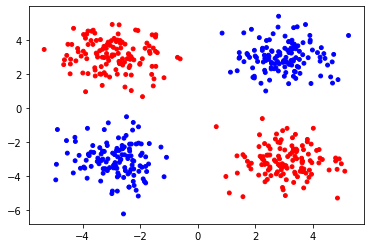

In [44]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: 0.59256218 + 0.00000000 = 0.59256218 loss_val = 0.59256218
epoch:  100/1000 loss_train: 0.01678145 + 0.00000000 = 0.01678145 loss_val = 0.01678145
epoch:  200/1000 loss_train: 0.00627380 + 0.00000000 = 0.00627380 loss_val = 0.00627380
epoch:  300/1000 loss_train: 0.00373002 + 0.00000000 = 0.00373002 loss_val = 0.00373002
epoch:  400/1000 loss_train: 0.00261607 + 0.00000000 = 0.00261607 loss_val = 0.00261607
epoch:  500/1000 loss_train: 0.00200155 + 0.00000000 = 0.00200155 loss_val = 0.00200155
epoch:  600/1000 loss_train: 0.00161829 + 0.00000000 = 0.00161829 loss_val = 0.00161829
epoch:  700/1000 loss_train: 0.00135834 + 0.00000000 = 0.00135834 loss_val = 0.00135834
epoch:  800/1000 loss_train: 0.00116977 + 0.00000000 = 0.00116977 loss_val = 0.00116977
epoch:  900/1000 loss_train: 0.00102706 + 0.00000000 = 0.00102706 loss_val = 0.00102706
epoch: 1000/1000 loss_train: 0.00091574 + 0.00000000 = 0.00091574 loss_val = 0.00091574
Acurácia: 100.00%


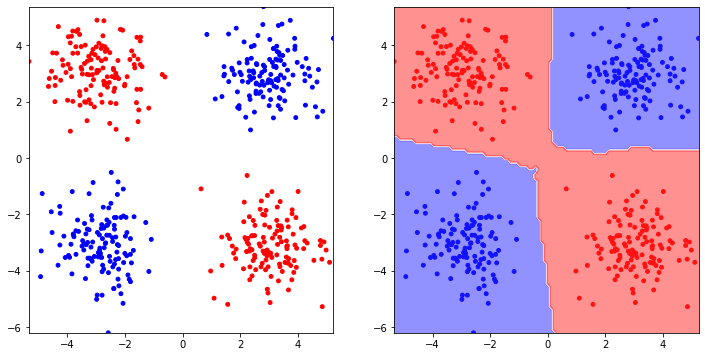

In [45]:
input_dim, output_dim = x.shape[1], y.shape[1]

#configuração da rede - problema de classificação binária (binary_cross_entropy)
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate = 1e-1)
#1 neurônio não é mais suficiente pois n da para separar as classes com uma reta. 
nn.layers.append(Layer(input_dim=input_dim, output_dim=4,activation=relu)) 
nn.layers.append(Layer(input_dim=4, output_dim=4,activation=relu)) 
nn.layers.append(Layer(input_dim=4, output_dim=output_dim,activation=sigmoid)) 
nn.fit(x, y, epochs=1000, verbose=100) #porque 1000 epochs ? tentativa e erro !! 

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(500, 2) (500, 1)


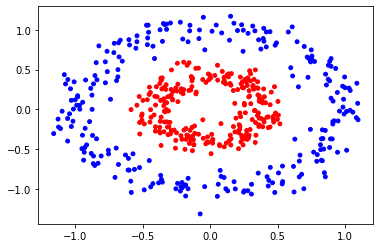

In [46]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: 1.13301538 + 0.00000000 = 1.13301538 loss_val = 1.13301538
epoch:  100/1000 loss_train: 0.33102428 + 0.00000000 = 0.33102428 loss_val = 0.33102428
epoch:  200/1000 loss_train: 0.07314612 + 0.00000000 = 0.07314612 loss_val = 0.07314612
epoch:  300/1000 loss_train: 0.03732935 + 0.00000000 = 0.03732935 loss_val = 0.03732935
epoch:  400/1000 loss_train: 0.02504310 + 0.00000000 = 0.02504310 loss_val = 0.02504310
epoch:  500/1000 loss_train: 0.01894154 + 0.00000000 = 0.01894154 loss_val = 0.01894154
epoch:  600/1000 loss_train: 0.01526341 + 0.00000000 = 0.01526341 loss_val = 0.01526341
epoch:  700/1000 loss_train: 0.01279568 + 0.00000000 = 0.01279568 loss_val = 0.01279568
epoch:  800/1000 loss_train: 0.01101420 + 0.00000000 = 0.01101420 loss_val = 0.01101420
epoch:  900/1000 loss_train: 0.00967176 + 0.00000000 = 0.00967176 loss_val = 0.00967176
epoch: 1000/1000 loss_train: 0.00862230 + 0.00000000 = 0.00862230 loss_val = 0.00862230
Acurácia: 100.00%


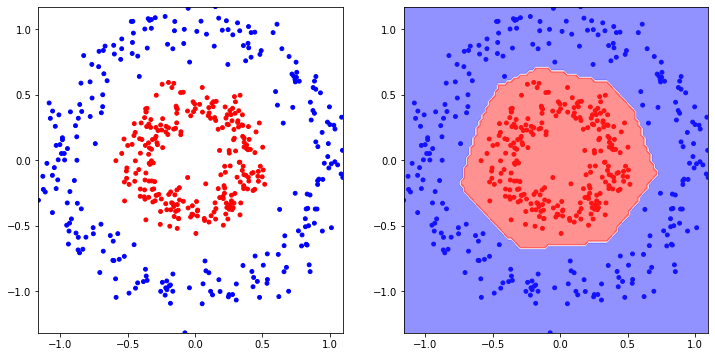

In [47]:
input_dim, output_dim = x.shape[1], y.shape[1]

#configuração da rede - problema de classificação binária (binary_cross_entropy)
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate = 1e-1)
#1 neurônio não é mais suficiente pois n da para separar as classes com uma reta. 8 neurônios por camada, porque ?
nn.layers.append(Layer(input_dim=input_dim, output_dim=8,activation=relu)) 
nn.layers.append(Layer(input_dim=8, output_dim=8,activation=relu)) 
nn.layers.append(Layer(input_dim=8, output_dim=output_dim,activation=sigmoid)) 
nn.fit(x, y, epochs=1000, verbose=100) #porque 1000 epochs ? tentativa e erro !! 

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

(200, 2) (200, 1)


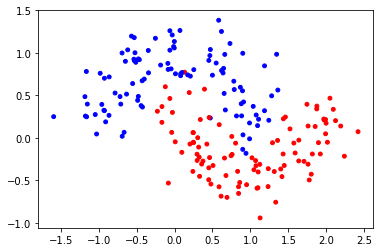

In [48]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/2000 loss_train: 0.61040867 + 0.06864366 = 0.67905233 loss_val = 0.61040867
epoch:  200/2000 loss_train: 0.30291856 + 0.05786655 = 0.36078512 loss_val = 0.30291856
epoch:  400/2000 loss_train: 0.27453958 + 0.05652464 = 0.33106422 loss_val = 0.27453958
epoch:  600/2000 loss_train: 0.26448891 + 0.05689870 = 0.32138761 loss_val = 0.26448891
epoch:  800/2000 loss_train: 0.25613515 + 0.05817255 = 0.31430770 loss_val = 0.25613515
epoch: 1000/2000 loss_train: 0.24749768 + 0.06021998 = 0.30771766 loss_val = 0.24749768
epoch: 1200/2000 loss_train: 0.23851132 + 0.06288425 = 0.30139557 loss_val = 0.23851132
epoch: 1400/2000 loss_train: 0.22954012 + 0.06596763 = 0.29550774 loss_val = 0.22954012
epoch: 1600/2000 loss_train: 0.22105064 + 0.06924947 = 0.29030011 loss_val = 0.22105064
epoch: 1800/2000 loss_train: 0.21339389 + 0.07251343 = 0.28590733 loss_val = 0.21339389
epoch: 2000/2000 loss_train: 0.20669545 + 0.07559595 = 0.28229139 loss_val = 0.20669545
Acurácia: 92.50%


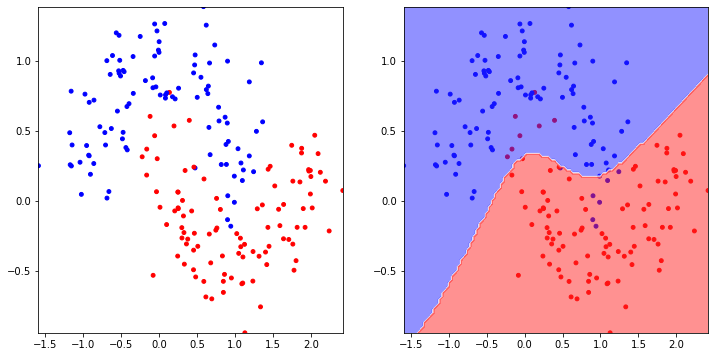

In [49]:
input_dim, output_dim = x.shape[1], y.shape[1]

# Usa regularização l1/l2 para reduzir o overfitting

#configuração da rede - problema de classificação binária (binary_cross_entropy)
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate = 1e-1)
#1 neurônio não é mais suficiente pois n da para separar as classes com uma reta. 

# relu ou tanh | reg_strength [0.1, 0.5, 1.0]
#nn.layers.append(Layer(input_dim=input_dim, output_dim=8,activation=tanh) # rede com overfit
#nn.layers.append(Layer(input_dim=8, output_dim=8,activation=relu))  remove-se uma camada e duplica as 1000 epochs

nn.layers.append(Layer(input_dim=input_dim, output_dim=8,activation=tanh,reg_strength=1.0, reg_func=l2_regularization)) #rede regularizada com l1
nn.layers.append(Layer(input_dim=8, output_dim=output_dim,activation=sigmoid,reg_strength=1.0, reg_func=l2_regularization)) 
nn.fit(x, y, epochs=2000, verbose=200) #porque 1000 epochs ? tentativa e erro !! 

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

(200, 2) (200, 1)


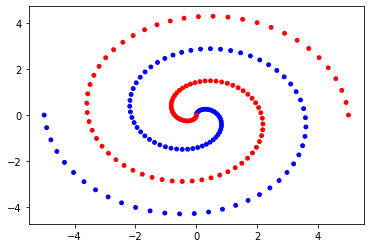

In [50]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000 loss_train: 1.39476907 + 0.00000000 = 1.39476907 loss_val = 1.39476907
epoch: 1000/5000 loss_train: 0.06543749 + 0.00000000 = 0.06543749 loss_val = 0.06543749
epoch: 2000/5000 loss_train: 0.01875836 + 0.00000000 = 0.01875836 loss_val = 0.01875836
epoch: 3000/5000 loss_train: 0.01320991 + 0.00000000 = 0.01320991 loss_val = 0.01320991
epoch: 4000/5000 loss_train: 0.01110260 + 0.00000000 = 0.01110260 loss_val = 0.01110260
epoch: 5000/5000 loss_train: 0.01002608 + 0.00000000 = 0.01002608 loss_val = 0.01002608
Acurácia: 99.50%


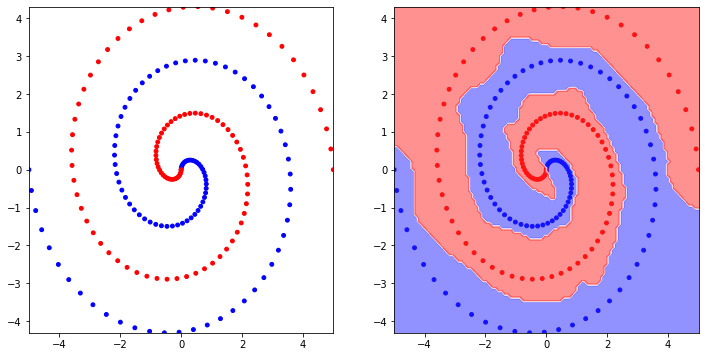

In [51]:
input_dim, output_dim = x.shape[1], y.shape[1]

#configuração da rede - problema de classificação binária (binary_cross_entropy)
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate = 1e-1)
#1 neurônio não é mais suficiente pois n da para separar as classes com uma reta. 
nn.layers.append(Layer(input_dim=input_dim, output_dim=20,activation=tanh)) # tanh pois incli sen/cos 
nn.layers.append(Layer(input_dim=20, output_dim=20,activation=tanh,batch_norm=True))  #uso da batch normalization - função de custo melhor e passamos de 10k para 5k epochs
nn.layers.append(Layer(input_dim=20, output_dim=output_dim,activation=sigmoid,batch_norm=True)) 
nn.fit(x, y, epochs=5000, verbose=1000) #porque 10000 epochs ? tentativa e erro !! 

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

(300, 2) (300, 1)


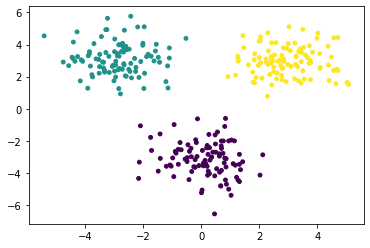

In [52]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [53]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


epoch:    0/1000 loss_train: 1.26174183 + 0.00000000 = 1.26174183 loss_val = 1.26174183
epoch:  100/1000 loss_train: 0.10318621 + 0.00000000 = 0.10318621 loss_val = 0.10318621
epoch:  200/1000 loss_train: 0.05195610 + 0.00000000 = 0.05195610 loss_val = 0.05195610
epoch:  300/1000 loss_train: 0.03430606 + 0.00000000 = 0.03430606 loss_val = 0.03430606
epoch:  400/1000 loss_train: 0.02547621 + 0.00000000 = 0.02547621 loss_val = 0.02547621
epoch:  500/1000 loss_train: 0.02020119 + 0.00000000 = 0.02020119 loss_val = 0.02020119
epoch:  600/1000 loss_train: 0.01670234 + 0.00000000 = 0.01670234 loss_val = 0.01670234
epoch:  700/1000 loss_train: 0.01421574 + 0.00000000 = 0.01421574 loss_val = 0.01421574
epoch:  800/1000 loss_train: 0.01235983 + 0.00000000 = 0.01235983 loss_val = 0.01235983
epoch:  900/1000 loss_train: 0.01092304 + 0.00000000 = 0.01092304 loss_val = 0.01092304
epoch: 1000/1000 loss_train: 0.00977886 + 0.00000000 = 0.00977886 loss_val = 0.00977886
Acurácia: 100.00%


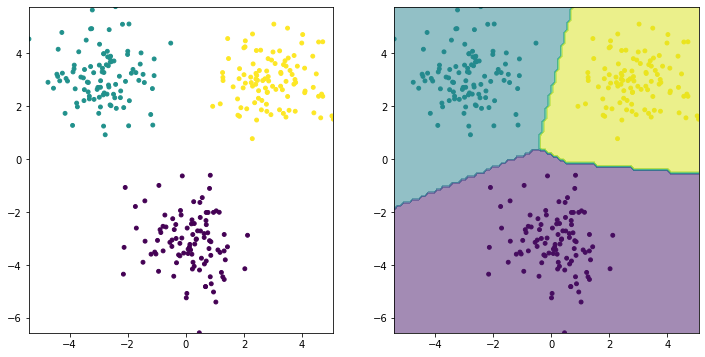

In [54]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

#configuração da rede - problema de classificação multiclasse (binary_cross_entropy)
nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=2,activation=relu)) # tanh tb serve
nn.layers.append(Layer(input_dim=2, output_dim=output_dim,activation=linear)) 
nn.fit(x, y_onehot, epochs=1000, verbose=100) #porque 10000 epochs ? tentativa e erro !! 
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

(400, 2) (400, 1)


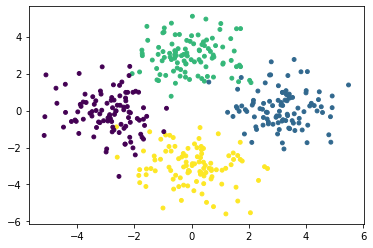

In [55]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [56]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


epoch:    0/1000 loss_train: 3.89102205 + 0.00000000 = 3.89102205 loss_val = 3.89102205
epoch:  100/1000 loss_train: 0.23377301 + 0.00000000 = 0.23377301 loss_val = 0.23377301
epoch:  200/1000 loss_train: 0.15175954 + 0.00000000 = 0.15175954 loss_val = 0.15175954
epoch:  300/1000 loss_train: 0.12299801 + 0.00000000 = 0.12299801 loss_val = 0.12299801
epoch:  400/1000 loss_train: 0.10906207 + 0.00000000 = 0.10906207 loss_val = 0.10906207
epoch:  500/1000 loss_train: 0.10097695 + 0.00000000 = 0.10097695 loss_val = 0.10097695
epoch:  600/1000 loss_train: 0.09571462 + 0.00000000 = 0.09571462 loss_val = 0.09571462
epoch:  700/1000 loss_train: 0.09200767 + 0.00000000 = 0.09200767 loss_val = 0.09200767
epoch:  800/1000 loss_train: 0.08924371 + 0.00000000 = 0.08924371 loss_val = 0.08924371
epoch:  900/1000 loss_train: 0.08710665 + 0.00000000 = 0.08710665 loss_val = 0.08710665
epoch: 1000/1000 loss_train: 0.08538875 + 0.00000000 = 0.08538875 loss_val = 0.08538875
Acurácia: 96.50%


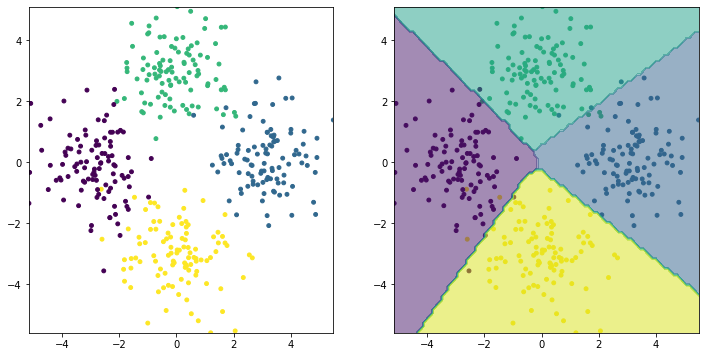

In [57]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]


#configuração da rede - problema de classificação multiclasse (binary_cross_entropy)
nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=3,activation=relu)) # tanh tb serve
nn.layers.append(Layer(input_dim=3, output_dim=output_dim,activation=linear)) 
nn.fit(x, y_onehot, epochs=1000, verbose=100) #porque 10000 epochs ? tentativa e erro !! 

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

(500, 2) (500, 1)


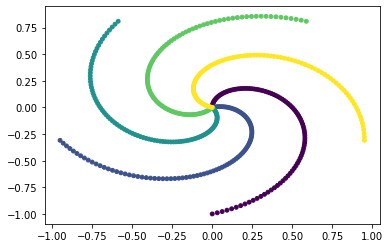

In [58]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [59]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


epoch:    0/2000 loss_train: 4.83575020 + 0.00000000 = 4.83575020 loss_val = 4.83575020
epoch:  200/2000 loss_train: 0.87097506 + 0.00000000 = 0.87097506 loss_val = 0.87097506
epoch:  400/2000 loss_train: 0.67541621 + 0.00000000 = 0.67541621 loss_val = 0.67541621
epoch:  600/2000 loss_train: 0.48566230 + 0.00000000 = 0.48566230 loss_val = 0.48566230
epoch:  800/2000 loss_train: 0.37394451 + 0.00000000 = 0.37394451 loss_val = 0.37394451
epoch: 1000/2000 loss_train: 0.30040417 + 0.00000000 = 0.30040417 loss_val = 0.30040417
epoch: 1200/2000 loss_train: 0.25054855 + 0.00000000 = 0.25054855 loss_val = 0.25054855
epoch: 1400/2000 loss_train: 0.21489919 + 0.00000000 = 0.21489919 loss_val = 0.21489919
epoch: 1600/2000 loss_train: 0.18810510 + 0.00000000 = 0.18810510 loss_val = 0.18810510
epoch: 1800/2000 loss_train: 0.16765178 + 0.00000000 = 0.16765178 loss_val = 0.16765178
epoch: 2000/2000 loss_train: 0.15179374 + 0.00000000 = 0.15179374 loss_val = 0.15179374
Acurácia: 96.20%


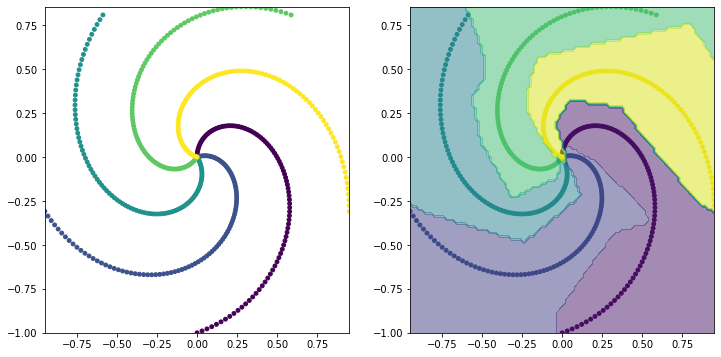

In [60]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]


#configuração da rede - problema de classificação multiclasse (binary_cross_entropy)
nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10,activation=relu)) # tanh tb serve
nn.layers.append(Layer(input_dim=10, output_dim=10,activation=relu)) # tanh tb serve
nn.layers.append(Layer(input_dim=10, output_dim=output_dim,activation=linear)) 
nn.fit(x, y_onehot, epochs=2000, verbose=200) #porque 2000 epochs ? tentativa e erro !! 

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

(100, 2) (100, 1)


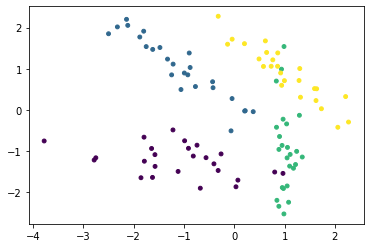

In [61]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [62]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


epoch:    0/2000 loss_train: 8.57778560 + 0.00000000 = 8.57778560 loss_val = 8.57778560
epoch:  200/2000 loss_train: 0.11796060 + 0.00000000 = 0.11796060 loss_val = 0.11796060
epoch:  400/2000 loss_train: 0.09944190 + 0.00000000 = 0.09944190 loss_val = 0.09944190
epoch:  600/2000 loss_train: 0.08571807 + 0.00000000 = 0.08571807 loss_val = 0.08571807
epoch:  800/2000 loss_train: 0.07593067 + 0.00000000 = 0.07593067 loss_val = 0.07593067
epoch: 1000/2000 loss_train: 0.06360846 + 0.00000000 = 0.06360846 loss_val = 0.06360846
epoch: 1200/2000 loss_train: 0.05605177 + 0.00000000 = 0.05605177 loss_val = 0.05605177
epoch: 1400/2000 loss_train: 0.05227318 + 0.00000000 = 0.05227318 loss_val = 0.05227318
epoch: 1600/2000 loss_train: 0.05637995 + 0.00000000 = 0.05637995 loss_val = 0.05637995
epoch: 1800/2000 loss_train: 0.04479843 + 0.00000000 = 0.04479843 loss_val = 0.04479843
epoch: 2000/2000 loss_train: 0.04066598 + 0.00000000 = 0.04066598 loss_val = 0.04066598
Acurácia: 100.00%


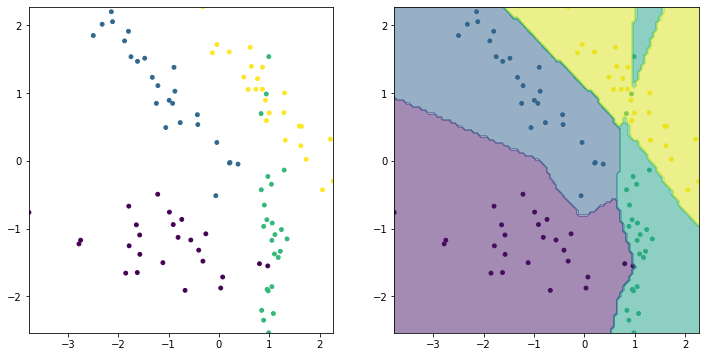

In [63]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

#configuração da rede - problema de classificação multiclasse (binary_cross_entropy)
nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10,activation=relu)) # tanh tb serve
nn.layers.append(Layer(input_dim=10, output_dim=10,activation=relu)) # tanh tb serve
nn.layers.append(Layer(input_dim=10, output_dim=output_dim,activation=linear)) 
nn.fit(x, y_onehot, epochs=2000, verbose=200) #porque 10000 epochs ? tentativa e erro !! 

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Iris Dataset

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


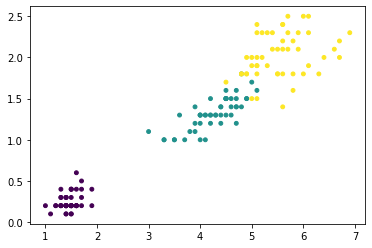

In [64]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [65]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


epoch:    0/2000 loss_train: 1.36154345 + 0.00000000 = 1.36154345 loss_val = 1.36154345
epoch:  200/2000 loss_train: 0.41102351 + 0.00000000 = 0.41102351 loss_val = 0.41102351
epoch:  400/2000 loss_train: 0.24623480 + 0.00000000 = 0.24623480 loss_val = 0.24623480
epoch:  600/2000 loss_train: 0.19018640 + 0.00000000 = 0.19018640 loss_val = 0.19018640
epoch:  800/2000 loss_train: 0.16555249 + 0.00000000 = 0.16555249 loss_val = 0.16555249
epoch: 1000/2000 loss_train: 0.14736708 + 0.00000000 = 0.14736708 loss_val = 0.14736708
epoch: 1200/2000 loss_train: 0.13435880 + 0.00000000 = 0.13435880 loss_val = 0.13435880
epoch: 1400/2000 loss_train: 0.12690954 + 0.00000000 = 0.12690954 loss_val = 0.12690954
epoch: 1600/2000 loss_train: 0.12118398 + 0.00000000 = 0.12118398 loss_val = 0.12118398
epoch: 1800/2000 loss_train: 0.11705588 + 0.00000000 = 0.11705588 loss_val = 0.11705588
epoch: 2000/2000 loss_train: 0.11426169 + 0.00000000 = 0.11426169 loss_val = 0.11426169
Acurácia: 96.00%


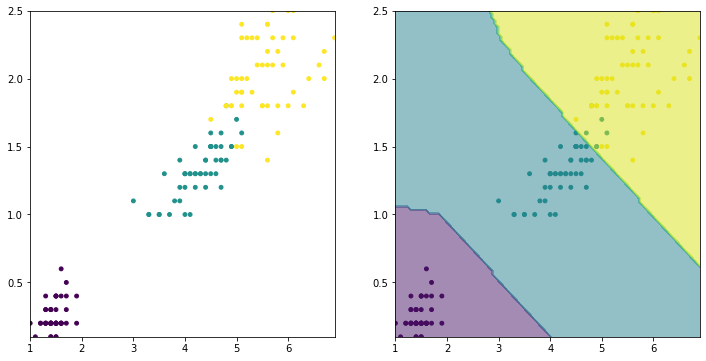

In [66]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

#configuração da rede - problema de classificação multiclasse (binary_cross_entropy)
#o uso de lr decay fez a rede aprender mais rápido, 600 epochs atingiu > 96%
#nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 1e-1)
nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 1e-1,lr_decay_method = exponential_decay, lr_decay_rate=1.0, lr_decay_steps=10)
#nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 1e-1,lr_decay_method = staircase_decay, lr_decay_rate=1.0, lr_decay_steps=10)
#nn = NeuralNetwork(cost_func = softmax_neg_log_likelihood, learning_rate = 1e-1,lr_decay_method =  time_based_decay, lr_decay_rate=0.1, lr_decay_steps=10)
nn.layers.append(Layer(input_dim=input_dim, output_dim=5,activation=relu)) # relu ou tanh 
nn.layers.append(Layer(input_dim=5, output_dim=output_dim,activation=linear)) 

#porque 2000 epochs ? tentativa e erro !! e mais, sendo 150 o total do dataset, o dividimos em 15 lotes de 10 linhas
#nn.fit(x, y_onehot, epochs=2000, verbose=200) #porque 2000 epochs ? tentativa e erro !! 
nn.fit(x, y_onehot, epochs=2000, verbose=200,batch_gen= batch_sequential, batch_size = 10) 

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Mapa Suscetibilidade POA

In [67]:
import os, sys
import pandas as pd
from sklearn.model_selection import train_test_split
APP_PATH = os.getcwd()
dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", "Input_POA.csv"))) #Input_POA  diabetes spc_data_landslides
dataset

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,13.452180,127.04240,59.22540,2230,2741,6.376712,0.008905,0
1,15.656500,110.69380,203.50100,1320,2741,5.476123,0.065837,0
2,1.895332,215.47270,10.00250,2110,2790,10.594538,-0.020116,0
3,1.016567,39.76366,5.45029,1620,2790,10.741805,-0.003531,0
4,11.090160,178.25730,68.48230,1210,2742,7.579783,-0.000890,0
...,...,...,...,...,...,...,...,...
95,37.890990,336.34500,177.72200,2230,2773,6.217178,-0.021211,1
96,7.045130,99.54131,37.76530,1420,2742,9.468263,-0.018692,1
97,16.295700,216.57440,106.03300,2230,2773,9.182029,-0.015873,1
98,3.906067,50.09582,19.37700,2210,1507,7.014249,-0.000092,0


In [68]:
# split data into X and y
X = dataset.drop('class',axis=1)
Y= dataset['class']
#X

In [69]:
X = X.to_numpy()    #converte dataframe em array
Y = Y.to_numpy()    #converte dataframe em array
Y = Y.reshape(-1,1) #reorganiza o array em um array 1 x 1
print(X.shape, Y.shape)

(100, 7) (100, 1)


In [70]:
minmax = MinMaxScaler(feature_range=(-1, 1))
X = minmax.fit_transform(X.astype(np.float64))
print(X.min(axis=0), X.max(axis=0))

[-1. -1. -1. -1. -1. -1. -1.] [1. 1. 1. 1. 1. 1. 1.]


In [71]:
# split data into training and testing sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [72]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

In [73]:
#configuração da rede - problema de classificação binária (binary_cross_entropy)
#nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate = 6*1e-1) # da Lucimara
nn = NeuralNetwork(cost_func = binary_cross_entropy, learning_rate = 5e-3) # Tentativa e Erro - Caio

nn.layers.append(Layer(input_dim=input_dim, output_dim=4,activation= tanh, weights_initializer=glorot_normal)) # tanh tb serve leaky_relu ou relu ou elu
nn.layers.append(Layer(input_dim=4, output_dim=4,activation= relu, weights_initializer=glorot_normal,biases_initializer=random_uniform)) # tanh tb serve leaky_relu ou relu ou elu
nn.layers.append(Layer(input_dim=4, output_dim=output_dim,activation=sigmoid,weights_initializer=glorot_uniform)) 

In [74]:
#nn.fit(X_train, y_train, epochs=200, verbose=20) # da Lucimara
nn.fit(X_train, y_train, epochs=18001, verbose=1000) 

epoch:    0/18001 loss_train: 1.05001783 + 0.00000000 = 1.05001783 loss_val = 1.05001783
epoch: 1000/18001 loss_train: 0.64116203 + 0.00000000 = 0.64116203 loss_val = 0.64116203
epoch: 2000/18001 loss_train: 0.46113306 + 0.00000000 = 0.46113306 loss_val = 0.46113306
epoch: 3000/18001 loss_train: 0.30265181 + 0.00000000 = 0.30265181 loss_val = 0.30265181
epoch: 4000/18001 loss_train: 0.23870223 + 0.00000000 = 0.23870223 loss_val = 0.23870223
epoch: 5000/18001 loss_train: 0.20528853 + 0.00000000 = 0.20528853 loss_val = 0.20528853
epoch: 6000/18001 loss_train: 0.18853467 + 0.00000000 = 0.18853467 loss_val = 0.18853467
epoch: 7000/18001 loss_train: 0.17553187 + 0.00000000 = 0.17553187 loss_val = 0.17553187
epoch: 8000/18001 loss_train: 0.16400281 + 0.00000000 = 0.16400281 loss_val = 0.16400281
epoch: 9000/18001 loss_train: 0.15442285 + 0.00000000 = 0.15442285 loss_val = 0.15442285
epoch: 10000/18001 loss_train: 0.14663376 + 0.00000000 = 0.14663376 loss_val = 0.14663376
epoch: 11000/18001 l

In [75]:
y_pred = nn.predict(X_test)
#print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

Acurácia: 75.76%


In [76]:
nn.save('suscetibilidadeNN.pkl')

In [77]:
#nn = None

In [78]:
y_pred = nn.predict(X_test)

In [79]:
nn = NeuralNetwork.load('suscetibilidadeNN.pkl')

In [80]:
#print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

Acurácia: 75.76%


### Early Stopping DEMO

In [81]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

x, y = make_regression(n_samples=100, n_features=1, n_informative=2, noise=10.0, random_state=42)
x,y = x.reshape(-1,1), y.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


In [82]:
nn = NeuralNetwork(cost_func=mse, learning_rate= 1e-1, patience=10) #se não melhorar em 10 epochs parar !!
nn.layers.append(Layer(input_dim=x.shape[1], output_dim=y.shape[1],activation=linear))
nn.fit(x_train,y_train,x_val=x_test, y_val=y_test, epochs=1000, verbose=50)

epoch:    0/1000 loss_train: 701.61840251 + 0.00000000 = 701.61840251 loss_val = 738.43817988
epoch:   50/1000 loss_train: 35.44910313 + 0.00000000 = 35.44910313 loss_val = 53.34950013
epoch:  100/1000 loss_train: 35.23224720 + 0.00000000 = 35.23224720 loss_val = 51.77156428
epoch:  150/1000 loss_train: 35.23214680 + 0.00000000 = 35.23214680 loss_val = 51.73728786
epoch:  200/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73653023
epoch:  250/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651378
epoch:  300/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651343
epoch:  350/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651342
epoch:  400/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651342
epoch:  450/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651342


[[44.33503]]
[[-0.36343]]


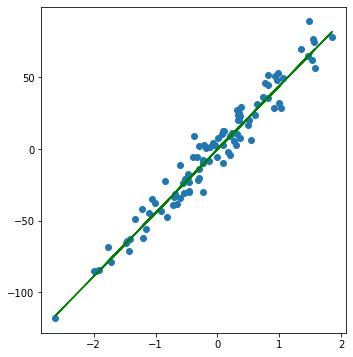

In [83]:

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

# [Link para o Questionário](https://docs.google.com/forms/d/e/1FAIpQLSf1B3JKsPPPc1oYD_3FyX4UvNLpcXnTW2I177A_WE0_B56Elw/viewform?usp=sf_link)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)
- [Implementing Neural Network L2 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/29/implementing-neural-network-l2-regularization/)
- [Neural Network L2 Regularization Using Python](https://visualstudiomagazine.com/articles/2017/09/01/neural-network-l2.aspx)

__Momentum__:
- [Neural Network Momentum Using Python](https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx)
- [Beyond SGD: Gradient Descent with Momentum and Adaptive Learning Rate](https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__Batch Normalization__:
- [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
- [Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
- [Implementing BatchNorm in Neural Net](https://wiseodd.github.io/techblog/2016/07/04/batchnorm/)
- [What does the gradient flowing through batch normalization looks like ?](http://cthorey.github.io./backpropagation/)
- [GRADIENTS, BATCH NORMALIZATION AND LAYER NORMALIZATION](https://theneuralperspective.com/2016/10/27/gradient-topics/)

__Gradient Checking__:
- [cs231n](https://github.com/cs231n/cs231n.github.io/blob/master/neural-networks-3.md#gradcheck)
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization)
- [BatchNormalization fails gradient checking](https://github.com/torch/nn/issues/744)